라이브러리

In [56]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, Attention, Input
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test230717_tank1_lstm_crop_only-feed'

In [57]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [58]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [59]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [60]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

japonica_training_sensor_val_tb.set_index('mea_dt', inplace=True)
japonica_validation_sensor_val_tb.set_index('mea_dt', inplace=True)

# 시간대 자르기
time_range_1 = pd.date_range(start='03:00:00', end='05:59:00', freq='T').time
time_range_2 = pd.date_range(start='15:00:00', end='17:59:00', freq='T').time

# 03:00:00 ~ 05:59:00 시간대의 데이터 중 180개가 있는 그룹만 추출
valid_data_1 = japonica_training_sensor_val_tb.between_time(time_range_1[0], time_range_1[-1])
valid_data_1 = valid_data_1.groupby(pd.Grouper(freq='D')).filter(lambda x: len(x) == 180)

# 15:00:00 ~ 17:59:00 시간대의 데이터 중 180개가 있는 그룹만 추출
valid_data_2 = japonica_training_sensor_val_tb.between_time(time_range_2[0], time_range_2[-1])
valid_data_2 = valid_data_2.groupby(pd.Grouper(freq='D')).filter(lambda x: len(x) == 180)

# 두 시간대의 데이터를 합침
valid_data = pd.concat([valid_data_1, valid_data_2])
japonica_training_sensor_crop = valid_data.sort_index()

# 시간대 자르기
time_range_1 = pd.date_range(start='03:00:00', end='05:59:00', freq='T').time
time_range_2 = pd.date_range(start='15:00:00', end='17:59:00', freq='T').time

# 03:00:00 ~ 05:59:00 시간대의 데이터 중 180개가 있는 그룹만 추출
valid_data_1 = japonica_validation_sensor_val_tb.between_time(time_range_1[0], time_range_1[-1])
valid_data_1 = valid_data_1.groupby(pd.Grouper(freq='D')).filter(lambda x: len(x) == 180)

# 15:00:00 ~ 17:59:00 시간대의 데이터 중 180개가 있는 그룹만 추출
valid_data_2 = japonica_validation_sensor_val_tb.between_time(time_range_2[0], time_range_2[-1])
valid_data_2 = valid_data_2.groupby(pd.Grouper(freq='D')).filter(lambda x: len(x) == 180)

# 두 시간대의 데이터를 합침
valid_data = pd.concat([valid_data_1, valid_data_2])
japonica_validation_sensor_crop = valid_data.sort_index()

#인덱스 복구
japonica_training_sensor_val_tb = japonica_training_sensor_crop.reset_index()
japonica_validation_sensor_val_tb = japonica_validation_sensor_crop.reset_index()

In [61]:
#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)

In [62]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']

In [63]:
japonica_training_data

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,,
2021-07-21 03:00:00,1,8.1,30.2,5.27,213.6,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:01:00,1,8.1,30.2,5.27,213.3,11.9,0.0,3.9,0.0,0.0
2021-07-21 03:02:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.1,0.0,0.0
2021-07-21 03:03:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:04:00,1,8.2,30.2,5.27,213.5,11.8,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-09-08 17:55:00,1,8.1,28.9,5.42,156.1,32.1,0.0,3.9,0.0,0.0
2021-09-08 17:56:00,1,8.2,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0
2021-09-08 17:57:00,1,8.3,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0


In [64]:
time_ranges = [('03:00:00', '05:59:00'), ('15:00:00', '17:59:00')]

japonica_training_data_feed = []
japonica_validation_data_feed = []

for time_range in time_ranges:
    start_time, end_time = time_range
    print(start_time)
    print(end_time)
    filtered_training_data = japonica_training_data.between_time(start_time, end_time)
    filtered_validation_data = japonica_validation_data.between_time(start_time, end_time)
    print(len(filtered_training_data))
    
    japonica_training_data_feed.append(filtered_training_data)
    japonica_validation_data_feed.append(filtered_validation_data)


japonica_training_data = pd.concat(japonica_training_data_feed)
japonica_validation_data = pd.concat(japonica_validation_data_feed)

03:00:00
05:59:00
8280
15:00:00
17:59:00
7920


In [65]:
japonica_training_data

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,,
2021-07-21 03:00:00,1,8.1,30.2,5.27,213.6,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:01:00,1,8.1,30.2,5.27,213.3,11.9,0.0,3.9,0.0,0.0
2021-07-21 03:02:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.1,0.0,0.0
2021-07-21 03:03:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:04:00,1,8.2,30.2,5.27,213.5,11.8,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-09-08 17:55:00,1,8.1,28.9,5.42,156.1,32.1,0.0,3.9,0.0,0.0
2021-09-08 17:56:00,1,8.2,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0
2021-09-08 17:57:00,1,8.3,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0


In [66]:
japonica_training_features_X = japonica_training_data[['feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]


japonica_validation_features_X = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [67]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_X_chunks = japonica_training_features_X_chunks.reshape((-1, 180, 1))
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)
japonica_training_features_y_chunks = japonica_training_features_y_chunks.reshape((-1, 180, 1))

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_X_chunks = japonica_validation_features_X_chunks.reshape((-1, 180, 1))
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)
japonica_validation_features_y_chunks = japonica_validation_features_y_chunks.reshape((-1, 180, 1))

In [68]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1
nCar: 90 nVar: 180
nCar: 90 nVar: 1
nCar: 90 nVar: 180


In [69]:
japonica_training_features_X_chunks.shape

(90, 180, 1)

LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [70]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(180, 1), return_sequences=False))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, epochs = 1000, batch_size = 32, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_4 (Dense)              (None, 180)               23220     
Total params: 89,780
Trainable params: 89,780
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3/3 [==============================] - 3s 305ms/step - loss: 73.6937 - mae: 8.4963 - r_squared: -48.8874 - val_loss: 73.6116 - val_mae: 8.4914 - val_r_squared: -48.8541
Epoch 2/1000
3/3 [==============================] - 0s 93ms/step - loss: 73.5428 - mae: 8.4874 - r_squared: -49.9608 - val_loss: 73.3132 - val_mae: 8.4738 - val_r_squared: -48.6522
Epoch 3/1000
3/3 [==============================] - 0s 67ms/step - loss: 72.9574 - mae: 8.4532 - r_squared: -56.3120 - val_loss: 69.7409 - val_mae: 8

모델 평가

In [71]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [72]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 1.08577318e-01 -1.12939313e-04  5.12135588e-02 -4.88844961e-02
  -4.11030352e-02  6.38981313e-02 -6.49958625e-02 -6.56676963e-02
  -7.86928460e-02  4.61721830e-02  4.53279018e-02 -2.40482967e-02
   5.12772240e-02 -2.01749876e-02  4.69608940e-02 -6.15079561e-03
  -8.84166956e-02  8.53213742e-02 -2.72753816e-02 -6.57372847e-02
  -6.87530711e-02  4.66204435e-02  3.73419859e-02 -2.20737346e-02
   9.49817896e-02 -2.28646770e-02  8.15636292e-02 -4.79148813e-02
  -8.39063972e-02 -8.23517218e-02  1.13672480e-01 -4.83575799e-02
  -6.20463043e-02 -7.20993653e-02 -1.06094308e-01  2.80247275e-02
  -5.64353988e-02  3.63716856e-02 -5.41388132e-02 -2.72898152e-02
   5.26280217e-02 -1.14926763e-01  5.57974242e-02 -4.14258689e-02
  -6.39656112e-02  7.15587363e-02  5.05275950e-02  6.72012102e-03
   2.55755410e-02 -6.85375333e-02  6.16856851e-02 -5.95226474e-02
   5.21415435e-02  5.30037545e-02  8.00189190e-03  5.28267249e-02
  -6.54975101e-02 -4.44181897e-02  7.84714445e-02  8.68840814e-02
   7.57953

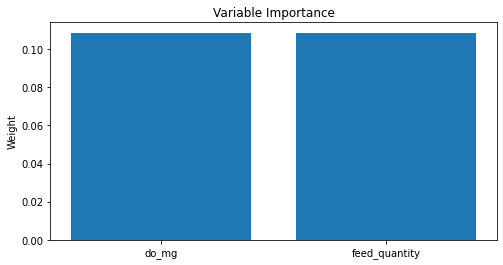

In [73]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [74]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1


In [75]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16200 nVar: 1
nCar: 90 nVar: 180


16200


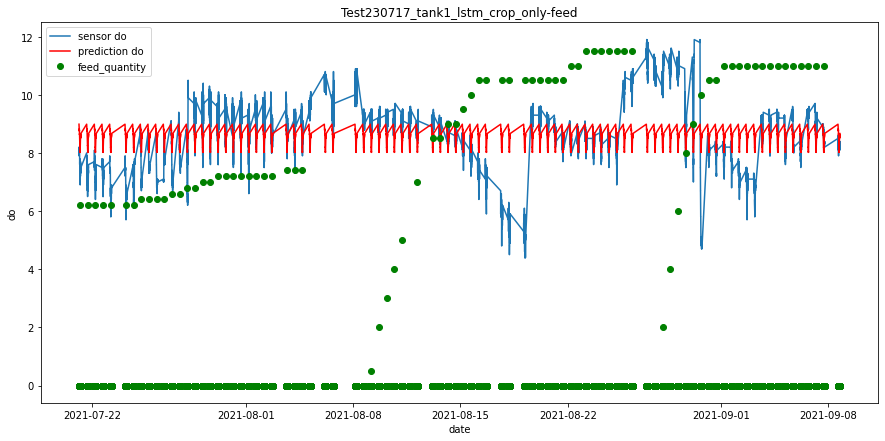

3/3 [==============================] - 0s 8ms/step - loss: 1.4363 - mae: 0.8985 - r_squared: 0.0278
MSE // MAE // R-squared  [1.4362587928771973, 0.8985369205474854, 0.027848362922668457]


In [76]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [77]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [78]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [79]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [80]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [81]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 360 nVar: 1


In [82]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 360 nVar: 180


64800


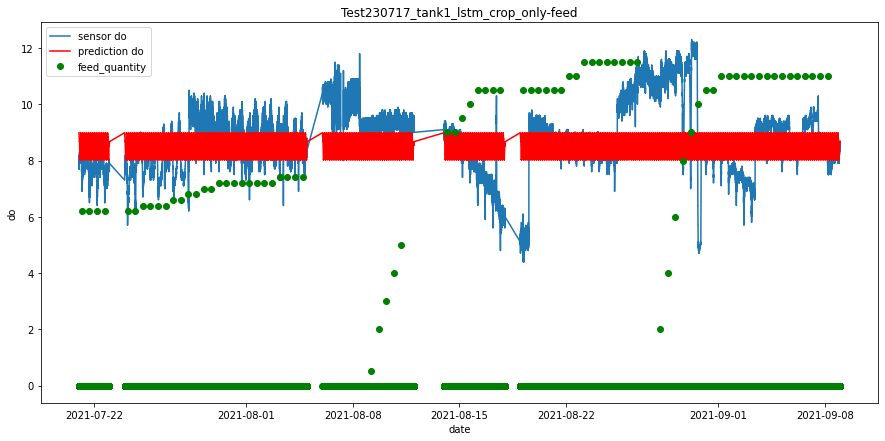

12/12 [==============================] - 0s 7ms/step - loss: 1.5878 - mae: 0.9452 - r_squared: -1.2282
MSE // MAE // R-squared  [1.587801218032837, 0.9451715350151062, -1.2281510829925537]


In [83]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [84]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-31 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 80 nVar: 1


In [85]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14400 nVar: 1
nCar: 80 nVar: 180


14400


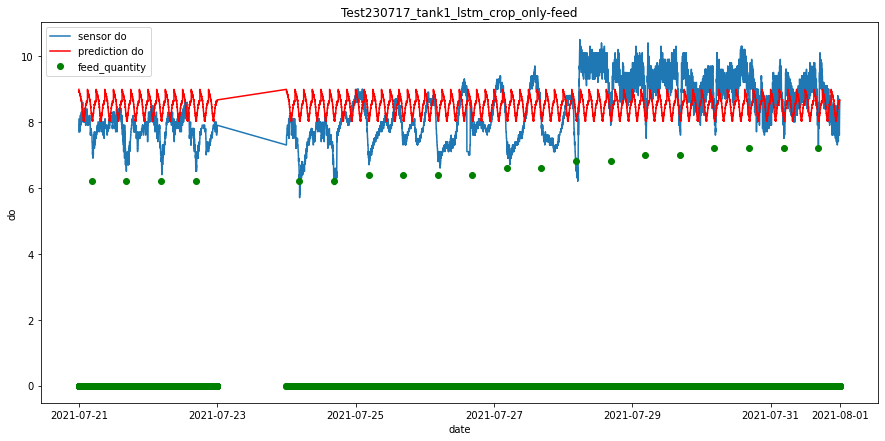

3/3 [==============================] - 0s 6ms/step - loss: 0.7903 - mae: 0.7479 - r_squared: -1.0240
MSE // MAE // R-squared  [0.7902845144271851, 0.7479358911514282, -1.0240089893341064]


In [86]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [87]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 8 nVar: 1


In [88]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 8 nVar: 180


1440


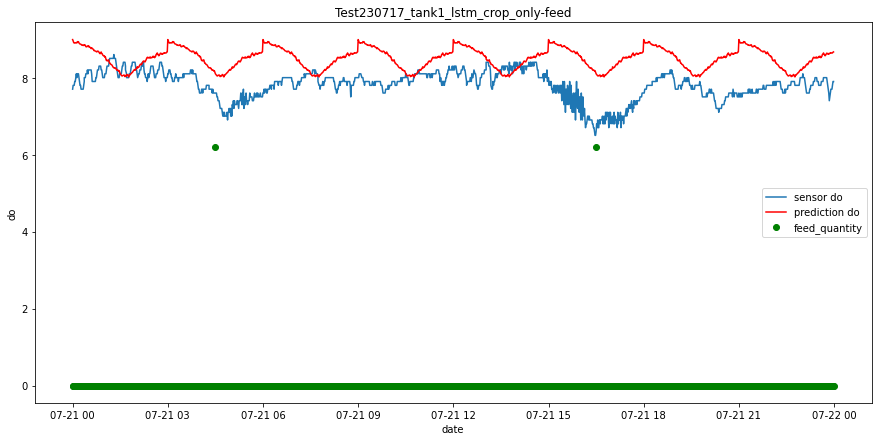

1/1 [==============================] - 0s 39ms/step - loss: 0.6608 - mae: 0.7068 - r_squared: -3.8095
MSE // MAE // R-squared  [0.6608412861824036, 0.7067561149597168, -3.809506416320801]


In [89]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [90]:
X = japonica_validation_data.loc['2021-07-21 04:30':'2021-07-21 16:29']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1


In [91]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


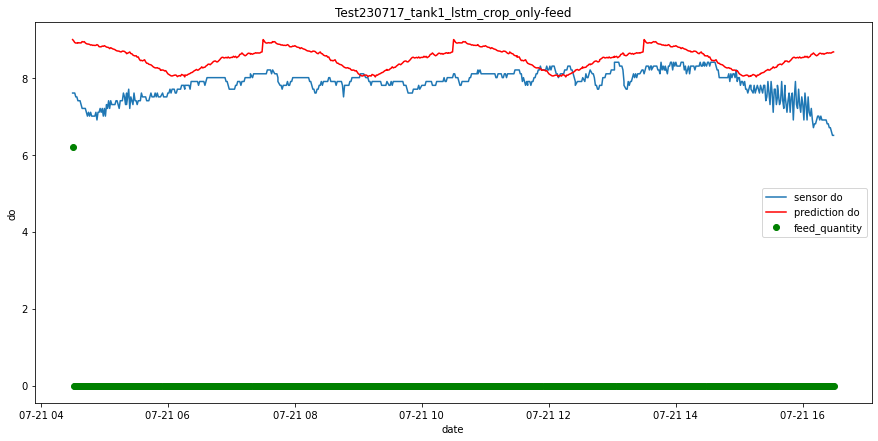

1/1 [==============================] - 0s 43ms/step - loss: 0.6364 - mae: 0.6654 - r_squared: -3.9020
MSE // MAE // R-squared  [0.6364177465438843, 0.6653925180435181, -3.9019808769226074]


In [92]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)